### 논문의 Table6 구현

/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT
JDINet + PostNet (rmse, psnr, ssim)
    mean : (0.05 +- 0.050, 26.88 +- 3.653, 0.68 +- 0.075)
w/o DeMo (rmse, psnr, ssim)
    mean : (0.07 +- 0.026, 23.90 +- 2.348, 0.52 +- 0.062)
w/o PostNet (rmse, psnr, ssim)
    mean : (0.06 +- 0.036, 25.48 +- 3.411, 0.69 +- 0.063)
w/o JDINet (rmse, psnr, ssim)
    mean : (0.13 +- 0.024, 17.95 +- 1.598, 0.35 +- 0.043)


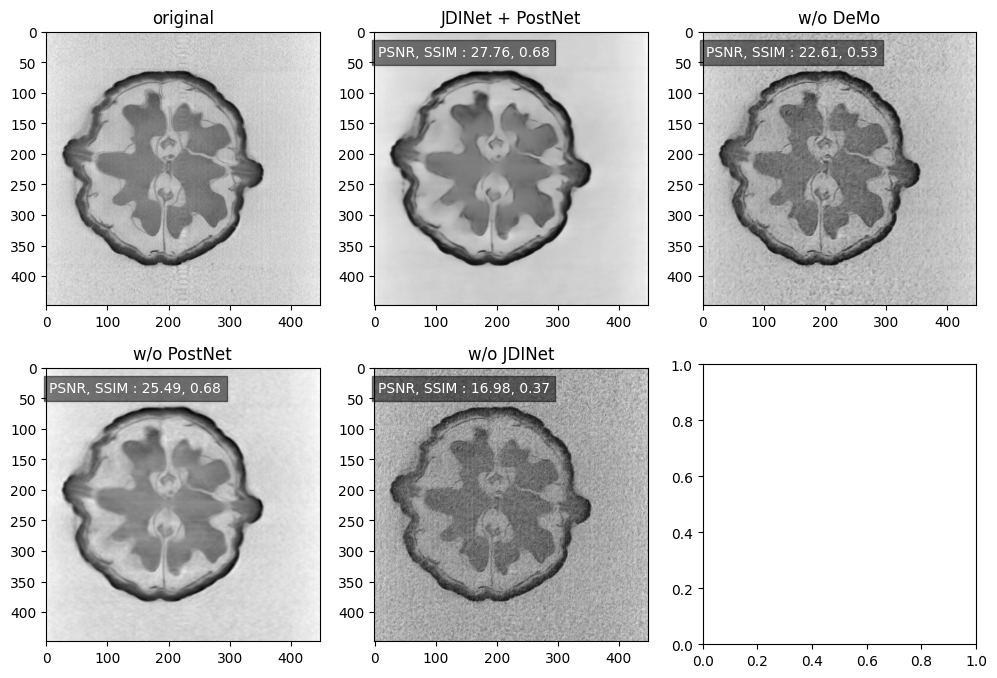

In [15]:
%cd /home/byeoli0832/sparse_view_test/FusionLowDoseCBCT
%pwd

import matplotlib.pyplot as plt
import imageio.v2 as iio
import os
import numpy as np
from scipy.ndimage import gaussian_filter
import math
from math import exp
import torch
import torch.nn.functional as F

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0).cuda()
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window


def compute_ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Grayscale 이미지 처리 (H, W) → (1, H, W)
    if img1.ndim == 2:  
        img1 = img1[..., np.newaxis]  # (H, W) → (H, W, 1)
        img2 = img2[..., np.newaxis]
    img1 = torch.from_numpy(img1).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)
    img2 = torch.from_numpy(img2).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)

    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)
    
    # mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    # mu2 = F.conv2d(img2, window, padding=padd, groups=channel)
    mu1 = F.conv2d(F.pad(img1, (5, 5, 5, 5), mode='replicate'), window, padding=padd, groups=channel)
    mu2 = F.conv2d(F.pad(img2, (5, 5, 5, 5), mode='replicate'), window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    # sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    # sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    # sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    sigma1_sq = F.conv2d(F.pad(img1 * img1, (5, 5, 5, 5), 'replicate'), window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(F.pad(img2 * img2, (5, 5, 5, 5), 'replicate'), window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(F.pad(img1 * img2, (5, 5, 5, 5), 'replicate'), window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret

def compute_rmse(img1, img2):
    """
    RMSE (Root Mean Square Error) 계산
    img1: 비교할 첫 번째 이미지 (numpy 배열)
    img2: 비교할 두 번째 이미지 (numpy 배열)
    """
    assert img1.shape == img2.shape, "두 이미지의 크기가 일치해야 합니다."
    
    mse = np.mean((img1 - img2) ** 2)  # Mean Squared Error (MSE) 계산
    rmse = np.sqrt(mse)  # RMSE 계산
    return rmse

def compute_psnr(img1, img2):
    """
    PSNR (Peak Signal-to-Noise Ratio) 계산
    img1: 비교할 첫 번째 이미지 (numpy 배열)
    img2: 비교할 두 번째 이미지 (numpy 배열)
    """
    max_pixel_value = np.max(img1)  # Ground-truth 이미지의 최대 픽셀 값
    rmse = compute_rmse(img1, img2)
    
    if rmse == 0:
        return float('inf')  # RMSE가 0이면 PSNR은 무한대

    psnr = 10 * np.log10((max_pixel_value ** 2) / (rmse ** 2))
    return psnr

def img_normal(img):
    return ((img - img.min()) / (img.max() - img.min())).astype(np.float32)

num_list = list(range(1,201))
img2_ssim = []
img3_ssim = []
img4_ssim = []
img5_ssim = []

img2_psnr = []
img3_psnr = []
img4_psnr = []
img5_psnr = []

img2_rmse = []
img3_rmse = []
img4_rmse = []
img5_rmse = []

origin_fdk = "/home/byeoli0832/sparse_view_test/walnut19_result/walnut19_div1_fdk"
fulll = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_19_full"
wo_demo = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_19_wo_demo"
wo_postnet = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_19_wo_postnet"
wo_jdinet = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_19_wo_jdinet"
for num in num_list:
  file_origin_name = f"fdk_{num:06d}.png"
  file_test_name = f"{num}.png"

  img1 = iio.imread(os.path.join(origin_fdk, file_origin_name))
  img2 = iio.imread(os.path.join(fulll, file_test_name))
  img3 = iio.imread(os.path.join(wo_demo, file_test_name))
  img4 = iio.imread(os.path.join(wo_postnet, file_test_name))
  img5 = iio.imread(os.path.join(wo_jdinet, file_test_name))
  img1_normal = img_normal(img1)
  img2_normal = img_normal(img2)
  img3_normal = img_normal(img3)
  img4_normal = img_normal(img4)
  img5_normal = img_normal(img5)
  img2_ssim.append(compute_ssim(img1_normal, img2_normal))
  img3_ssim.append(compute_ssim(img1_normal, img3_normal))
  img4_ssim.append(compute_ssim(img1_normal, img4_normal))
  img5_ssim.append(compute_ssim(img1_normal, img5_normal))

  img2_psnr.append(compute_psnr(img1_normal, img2_normal))
  img3_psnr.append(compute_psnr(img1_normal, img3_normal))
  img4_psnr.append(compute_psnr(img1_normal, img4_normal))
  img5_psnr.append(compute_psnr(img1_normal, img5_normal))

  img2_rmse.append(compute_rmse(img1_normal, img2_normal))
  img3_rmse.append(compute_rmse(img1_normal, img3_normal))
  img4_rmse.append(compute_rmse(img1_normal, img4_normal))
  img5_rmse.append(compute_rmse(img1_normal, img5_normal))


origin_fdk = "/home/byeoli0832/sparse_view_test/walnut20_result/walnut20_div1_fdk"
fulll = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_20_full"
wo_demo = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_20_wo_demo"
wo_postnet = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_20_wo_postnet"
wo_jdinet = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_20_wo_jdinet"
for num in num_list:
  file_origin_name = f"fdk_{num:06d}.png"
  file_test_name = f"{num}.png"

  img1 = iio.imread(os.path.join(origin_fdk, file_origin_name))
  img2 = iio.imread(os.path.join(fulll, file_test_name))
  img3 = iio.imread(os.path.join(wo_demo, file_test_name))
  img4 = iio.imread(os.path.join(wo_postnet, file_test_name))
  img5 = iio.imread(os.path.join(wo_jdinet, file_test_name))
  img1_normal = img_normal(img1)
  img2_normal = img_normal(img2)
  img3_normal = img_normal(img3)
  img4_normal = img_normal(img4)
  img5_normal = img_normal(img5)
  img2_ssim.append(compute_ssim(img1_normal, img2_normal))
  img3_ssim.append(compute_ssim(img1_normal, img3_normal))
  img4_ssim.append(compute_ssim(img1_normal, img4_normal))
  img5_ssim.append(compute_ssim(img1_normal, img5_normal))

  img2_psnr.append(compute_psnr(img1_normal, img2_normal))
  img3_psnr.append(compute_psnr(img1_normal, img3_normal))
  img4_psnr.append(compute_psnr(img1_normal, img4_normal))
  img5_psnr.append(compute_psnr(img1_normal, img5_normal))

  img2_rmse.append(compute_rmse(img1_normal, img2_normal))
  img3_rmse.append(compute_rmse(img1_normal, img3_normal))
  img4_rmse.append(compute_rmse(img1_normal, img4_normal))
  img5_rmse.append(compute_rmse(img1_normal, img5_normal))


origin_fdk = "/home/byeoli0832/sparse_view_test/walnut21_result/walnut21_div1_fdk"
fulll = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_21_full"
wo_demo = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_21_wo_demo"
wo_postnet = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_21_wo_postnet"
wo_jdinet = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_21_wo_jdinet"
for num in num_list:
  file_origin_name = f"fdk_{num:06d}.png"
  file_test_name = f"{num}.png"

  img1 = iio.imread(os.path.join(origin_fdk, file_origin_name))
  img2 = iio.imread(os.path.join(fulll, file_test_name))
  img3 = iio.imread(os.path.join(wo_demo, file_test_name))
  img4 = iio.imread(os.path.join(wo_postnet, file_test_name))
  img5 = iio.imread(os.path.join(wo_jdinet, file_test_name))
  img1_normal = img_normal(img1)
  img2_normal = img_normal(img2)
  img3_normal = img_normal(img3)
  img4_normal = img_normal(img4)
  img5_normal = img_normal(img5)
  img2_ssim.append(compute_ssim(img1_normal, img2_normal))
  img3_ssim.append(compute_ssim(img1_normal, img3_normal))
  img4_ssim.append(compute_ssim(img1_normal, img4_normal))
  img5_ssim.append(compute_ssim(img1_normal, img5_normal))

  img2_psnr.append(compute_psnr(img1_normal, img2_normal))
  img3_psnr.append(compute_psnr(img1_normal, img3_normal))
  img4_psnr.append(compute_psnr(img1_normal, img4_normal))
  img5_psnr.append(compute_psnr(img1_normal, img5_normal))

  img2_rmse.append(compute_rmse(img1_normal, img2_normal))
  img3_rmse.append(compute_rmse(img1_normal, img3_normal))
  img4_rmse.append(compute_rmse(img1_normal, img4_normal))
  img5_rmse.append(compute_rmse(img1_normal, img5_normal))

print(f"JDINet + PostNet (rmse, psnr, ssim)")
print(f"    mean : ({np.mean(img2_rmse):0.2f} +- {np.std(img2_rmse):0.3f}, {np.mean(img2_psnr):0.2f} +- {np.std(img2_psnr):0.3f}, {np.mean(img2_ssim):0.2f} +- {np.std(img2_ssim):0.3f})")
print(f"w/o DeMo (rmse, psnr, ssim)")
print(f"    mean : ({np.mean(img3_rmse):0.2f} +- {np.std(img3_rmse):0.3f}, {np.mean(img3_psnr):0.2f} +- {np.std(img3_psnr):0.3f}, {np.mean(img3_ssim):0.2f} +- {np.std(img3_ssim):0.3f})")
print(f"w/o PostNet (rmse, psnr, ssim)")
print(f"    mean : ({np.mean(img4_rmse):0.2f} +- {np.std(img4_rmse):0.3f}, {np.mean(img4_psnr):0.2f} +- {np.std(img4_psnr):0.3f}, {np.mean(img4_ssim):0.2f} +- {np.std(img4_ssim):0.3f})")
print(f"w/o JDINet (rmse, psnr, ssim)")
print(f"    mean : ({np.mean(img5_rmse):0.2f} +- {np.std(img5_rmse):0.3f}, {np.mean(img5_psnr):0.2f} +- {np.std(img5_psnr):0.3f}, {np.mean(img5_ssim):0.2f} +- {np.std(img5_ssim):0.3f})")



num = 51
file_origin_name = f"fdk_{num:06d}.png"
file_test_name = f"{num}.png"
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

origin_fdk = "/home/byeoli0832/sparse_view_test/walnut21_result/walnut21_div1_fdk"
fulll = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_21_full"
wo_demo = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_21_wo_demo"
wo_postnet = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_21_wo_postnet"
wo_jdinet = "/home/byeoli0832/sparse_view_test/FusionLowDoseCBCT/walnut_21_wo_jdinet"

img1 = iio.imread(os.path.join(origin_fdk, file_origin_name))
img2 = iio.imread(os.path.join(fulll, file_test_name))
img3 = iio.imread(os.path.join(wo_demo, file_test_name))
img4 = iio.imread(os.path.join(wo_postnet, file_test_name))
img5 = iio.imread(os.path.join(wo_jdinet, file_test_name))

img1_normal = img_normal(img1)
img2_normal = img_normal(img2)
img3_normal = img_normal(img3)
img4_normal = img_normal(img4)
img5_normal = img_normal(img5)

font = 10

ax[0][0].imshow(img1, cmap='gray')
ax[0][0].set_title("original")

ax[0][1].imshow(img2, cmap='gray')
ax[0][1].set_title("JDINet + PostNet")
ax[0][1].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img2_normal):.2f}, {compute_ssim(img1_normal, img2_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[0][2].imshow(img3, cmap='gray')
ax[0][2].set_title("w/o DeMo")
ax[0][2].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img3_normal):.2f}, {compute_ssim(img1_normal, img3_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[1][0].imshow(img4, cmap='gray')
ax[1][0].set_title("w/o PostNet")
ax[1][0].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img4_normal):.2f}, {compute_ssim(img1_normal, img4_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

ax[1][1].imshow(img5, cmap='gray')
ax[1][1].set_title("w/o JDINet")
ax[1][1].text(5, 40, f"PSNR, SSIM : {compute_psnr(img1_normal, img5_normal):.2f}, {compute_ssim(img1_normal, img5_normal):.2f}", 
fontsize=font, color="white", bbox=dict(facecolor='black', alpha=0.5))

plt.show()